In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from macrosim.SeriesAccessor import SeriesAccessor
from macrosim.EqSearch import EqSearch
from macrosim.SimEngine import SimEngine

import corner

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
fred = SeriesAccessor(key_path='./fred_key.env', key_name='fred_key')

In [3]:
start = dt.datetime.fromisoformat("2000-01-01")
end = dt.datetime.fromisoformat("2024-01-01")

In [ ]:
df = fred.get_series(series_ids=['NETEXP', 'CIVPART','LES1252881600Q', 'SPPOPGROWUSA', 'CORESTICKM159SFRBATL', 'GDPC1'], date_range=(start, end), reindex_freq='QS', series_alias=['NETEXP', 'CIVPART', 'RWAGE', 'POPGROWTH', 'CPI', 'RGDP'])

In [5]:
df = fred.fill(
    df,
    [ *[None]*3, 'ffill' ]
)
df

,NETEXP,CIVPART,RWAGE,POPGROWTH,CPI,RGDP
2000-01-01,-356.583,67.3,334.0,1.112769,2.335519,13878.147
2000-04-01,-362.501,67.3,334.0,1.112769,2.409239,14130.908
2000-07-01,-393.867,66.9,335.0,1.112769,2.712970,14145.312
2000-10-01,-411.343,66.8,334.0,1.112769,2.919941,14229.765
2001-01-01,-402.653,67.2,333.0,0.989741,2.878468,14183.120
...,...,...,...,...,...,...
2023-01-01,-813.648,62.4,364.0,0.491925,6.488339,22403.435
2023-04-01,-803.479,62.6,365.0,0.491925,6.267738,22539.418
2023-07-01,-781.091,62.6,366.0,0.491925,5.402919,22780.933
2023-10-01,-791.152,62.7,370.0,0.491925,4.882717,22960.600


In [6]:
#corner.corner(df, labels=df.columns, bins=10)

In [7]:
eqsr = EqSearch(
    X=df.drop(columns=['RGDP']),
    y=df['RGDP']
)

In [8]:
eqsr.distil_split()

RandomForest Score at Distillation: 0.961883728802177


In [9]:
eqsr.search()

Compiling Julia backend...
C:\Users\Gong Jr\.conda\envs\MacroSim\Lib\site-packages\pysr\sr.py:87: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.890e+05
Progress: 775 / 9300 total iterations (8.333%)
????????????????????????????????????????????????????????????????????????????????????????????????????
???????????????????????????????????????????????????????????????????????????????????????????????????
Complexity  Loss       Score      Equation
1           6.181e+06  1.594e+01  y = 17906
3           2.870e+06  3.836e-01  y = RWAGE ^ 1.6764
5           1.113e+06  4.735e-01  y = (-1252.3 * CIVPART) + 98428
7           9.274e+05  9.130e-02  y = ((CIVPART * -1224.9) + 96065) - NETEXP
9           4.385e+05  3.745e-01  y = ((CIVPART * -1103.7) + 87230) - (CPI * NETEXP)
11          3.970e+05  4.966e-02  y = (((-191.06 - NETEXP) * CPI) + (CIVPART * -1114.6)) + 8...
                                      8427
13          3.967e+05  3.735e-04  y = (CIVPART * -1164.1) + (((CPI * 585.61) - (NETEXP + NET...
                                      EXP)) - -90026)
15          3.967e+05  5.690e-05  y = (((-185.3 - 

[ Info: Final population:
[ Info: Results saved to:


complexity                                                      30
loss                                                     162170.56
equation         ((-815.2738 - (-1.5747097 / cos(sqrt(inv(POPGR...
score                                                     0.000003
sympy_format     CIVPART*(-815.2738 + 1.5747097/cos(sqrt(1/POPG...
lambda_format    PySRFunction(X=>CIVPART*(-815.2738 + 1.5747097...
Name: 22, dtype: object


In [10]:
act = df['RGDP']
pred_values = [eqsr.eq.subs(row[1].to_dict()).evalf() for row in df.drop('RGDP', axis=1).iterrows()]
pred = pd.Series(pred_values, index=df.index)

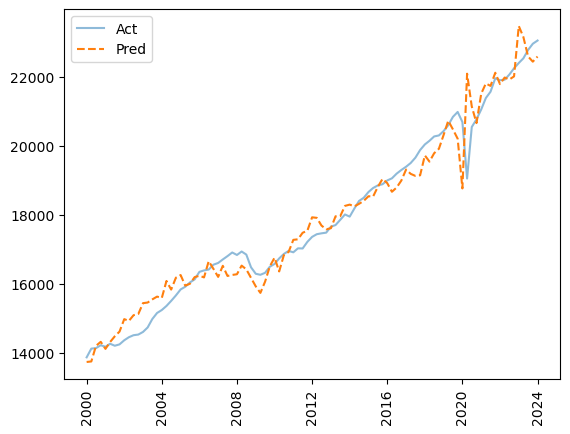

In [11]:
plt.plot(act, label='Act', alpha=0.5)
plt.plot(pred, label='Pred', linestyle='--')

plt.xticks(rotation=90)

plt.legend()
plt.show()

In [12]:
eqsr.eq

CIVPART*(-815.2738 + 1.5747097/cos(sqrt(1/POPGROWTH))) - 1.2086407*CPI*(NETEXP + 378.9959) - 1362.2983*POPGROWTH + 30.682066*RWAGE + 59761.605

In [46]:
engine = SimEngine(
    eq=eqsr.eq,
    init_params={
        'NETEXP': (-500, lambda x: x),
        'CIVPART': (70, lambda x: x),
        'RWAGE': (400, lambda x: x*1.01),
        'POPGROWTH': (1, lambda x: x*1.02),
        'CPI': (4, lambda x: x)
    }
)

In [47]:
for _ in range(100):
    next(engine._simulate())
engine.get_history()

,NETEXP,CIVPART,RWAGE,POPGROWTH,CPI,output
step,,,,,,
0,-506.208927,69.758037,410.541654,1.058837,3.976585,14391.983843
1,-503.245871,72.512107,422.602435,1.067338,4.030523,14849.774651
2,-497.415545,71.667831,429.410369,1.036611,3.856715,12963.331540
3,-490.423282,69.853146,437.111734,1.033341,3.720544,13850.991234
4,-508.392988,69.458866,442.228165,1.016465,3.669909,15515.587941
...,...,...,...,...,...,...
95,-447.581656,84.875114,856.400500,8.935510,3.544849,6720.095140
96,-446.150317,82.847574,830.226528,9.160581,3.477821,5103.804556
97,-430.286843,81.508399,815.856065,9.737900,3.554475,5631.970027


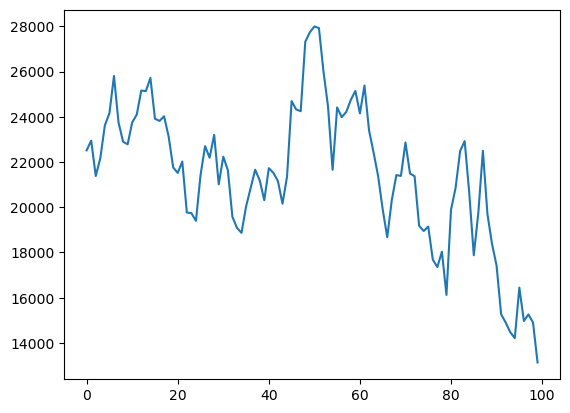

In [43]:
plt.plot(engine.get_history()['output'])

In [51]:
from macrosim.GrowthPatternDetector import GrowthPatternDetector
gpd = GrowthPatternDetector()

In [53]:
gpd.fit_pattern(df)

TypeError: 'numpy.float64' object is not iterable